# Multi-class text classification using BERT

In [ ]:
!nvidia-smi

In [ ]:
!pip install transformers

In [4]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
data_dir = "/content/drive/MyDrive/Notebooks_BERT/data"
df_data = pd.read_csv(os.path.join(data_dir,"input","arxiv-preproc-data.tsv"), sep="\t")

In [6]:
# Subsample the data
# we randomly subsample abstracts with a single category
df_data = df_data.loc[df_data.iloc[:,2:].apply(sum, axis=1) == 1,:].sample(n = 10_000, random_state = 4)
#df_data = df_data.sample(n = 10_000, random_state = 4)

In [7]:
df_data.head()

,abstract,title,astro-ph,cond-mat,cs,hep-ph,hep-th,math,physics,quant-ph
56126,Let $\Gamma$ be a group and $r_n(\Gamma)$ th...,Representation Growth of Linear Groups,0,0,0,0,0,1,0,0
1297674,In these lecture notes I briefly discuss the...,The Zoo of Neutron Stars,1,0,0,0,0,0,0,0
161188,"According to thermodynamics, the specific he...",Can one measure negative specific heat in the ...,0,1,0,0,0,0,0,0
1351481,We have observed the formation of ripples in...,Ion beam sputtering induced ripple formation i...,0,1,0,0,0,0,0,0
209144,The problem of determining total distance as...,Evaluating cumulative ascent: Mountain biking ...,0,0,0,0,0,0,1,0


In [8]:
# Combine title and abstract to increase power
df_data["combined"] = df_data["title"] + ". " + df_data["abstract"]
df_data.drop(columns=["abstract", "title"], axis=1, inplace=True)

In [9]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(df_data, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [10]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (7000, 9), Test: (1500, 9), Valid: (1500, 9)


In [11]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-05

In [12]:
from transformers import BertTokenizer, BertModel

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text, 
                                  add_special_tokens = True,
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length", 
                                  return_attention_mask = True, 
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
encodings

{'input_ids': tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [15]:
df_train['combined']

1451241    The Goldberger -- Treiman Relation, $g_A$ and ...
549359     Generation and detection of pure valley curren...
127093     Collections of Fluid Loaded Plates: A Nonlocal...
564537     Nonlinear buckling and symmetry breaking of a ...
1049852    Sharp estimate on the inner distance in planar...
                                 ...                        
964884     SU(2) Quantum Yang-Mills Thermodynamics: Some ...
336636     LP Rounding for k-Centers with Non-uniform Har...
1109090    Prominent room temperature valley polarization...
646538     Limit algebras and integer-valued cocycles, re...
1276669    Spectral constraints on unidentified EGRET gam...
Name: combined, Length: 7000, dtype: object

In [16]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['combined'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [17]:
target_list = list(df_data.columns)
target_list

['astro-ph',
 'cond-mat',
 'cs',
 'hep-ph',
 'hep-th',
 'math',
 'physics',
 'quant-ph',
 'combined']

In [18]:
target_list = target_list[:-1]

In [19]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [20]:
# testing the dataset
next(iter(train_dataset))

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([  101,  1996, 18522,  2121,  1011,  1011, 29461, 18505,  7189,  1010,
          1002,  1043

In [21]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [22]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 8)
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [23]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [24]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)         

In [25]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy
        _, preds = torch.max(outputs, dim=1) # batch dim 
        _, targ = torch.max(targets, dim=1)  # batch dim
        num_samples += len(targ)  # technically adding batch size
        correct_predictions += torch.sum(preds == targ)

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [26]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            _, preds = torch.max(outputs, dim=1) # batch dim 
            _, targ = torch.max(targets, dim=1)  # batch dim
            num_samples += len(targ)  # technically adding batch size
            correct_predictions += torch.sum(preds == targ)

    return float(correct_predictions)/num_samples, np.mean(losses)

## Model Training

In [26]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), os.path.join(data_dir,"output","best_model_state.bin"))
        best_accuracy = val_acc

Epoch 1/10


  0%|          | 0/219 [00:00<?, ?it/s]

train_loss=0.3360, val_loss=0.1970 train_acc=0.5540, val_acc=0.7380
Epoch 2/10


  0%|          | 0/219 [00:00<?, ?it/s]

train_loss=0.1691, val_loss=0.1357 train_acc=0.8020, val_acc=0.8480
Epoch 3/10


  0%|          | 0/219 [00:00<?, ?it/s]

train_loss=0.1169, val_loss=0.1074 train_acc=0.8904, val_acc=0.8800
Epoch 4/10


  0%|          | 0/219 [00:00<?, ?it/s]

train_loss=0.0863, val_loss=0.0967 train_acc=0.9249, val_acc=0.8780
Epoch 5/10


  0%|          | 0/219 [00:00<?, ?it/s]

train_loss=0.0660, val_loss=0.0952 train_acc=0.9463, val_acc=0.8787
Epoch 6/10


  0%|          | 0/219 [00:00<?, ?it/s]

train_loss=0.0521, val_loss=0.0897 train_acc=0.9611, val_acc=0.8893
Epoch 7/10


  0%|          | 0/219 [00:00<?, ?it/s]

train_loss=0.0429, val_loss=0.0931 train_acc=0.9684, val_acc=0.8833
Epoch 8/10


  0%|          | 0/219 [00:00<?, ?it/s]

train_loss=0.0330, val_loss=0.0921 train_acc=0.9796, val_acc=0.8800
Epoch 9/10


  0%|          | 0/219 [00:00<?, ?it/s]

train_loss=0.0267, val_loss=0.0982 train_acc=0.9854, val_acc=0.8807
Epoch 10/10


  0%|          | 0/219 [00:00<?, ?it/s]

train_loss=0.0221, val_loss=0.1002 train_acc=0.9884, val_acc=0.8767


In [38]:
import matplotlib.pyplot as plt

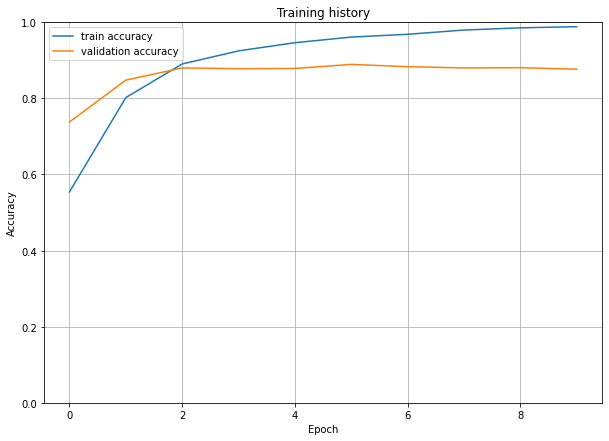

In [28]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

## Evaluation of the model

In [28]:
# Loading pretrained model
model = BERTClass()
model.load_state_dict(torch.load(os.path.join(data_dir,"output","MCTC_model_state.bin")))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
# Evaluate the model using the test data
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

In [31]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
test_acc

0.8913333333333333

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

In [33]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        _, preds = torch.max(outputs, dim=1)
        _, targ = torch.max(targets, dim=1)

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targ)
        
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    target_values = torch.stack(target_values).cpu()
    
    return titles, predictions, prediction_probs, target_values

In [34]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [35]:
# Classification report
print(classification_report(target_values, predictions, target_names=target_list))

              precision    recall  f1-score   support

    astro-ph       0.97      0.96      0.96       242
    cond-mat       0.87      0.91      0.89       232
          cs       0.91      0.91      0.91       245
      hep-ph       0.92      0.87      0.89       106
      hep-th       0.84      0.88      0.86        97
        math       0.94      0.90      0.92       419
     physics       0.63      0.65      0.64        91
    quant-ph       0.77      0.84      0.80        68

    accuracy                           0.89      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.89      0.89      0.89      1500



In [39]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True category')
    plt.xlabel('Predicted category');

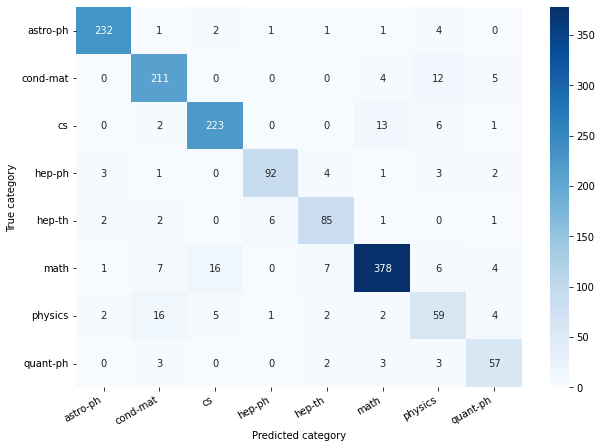

In [41]:
plt.rcParams["figure.figsize"] = (10,7)
cm = confusion_matrix(target_values, predictions)
df_cm = pd.DataFrame(cm, index=target_list, columns=target_list)
show_confusion_matrix(df_cm)

In [37]:
# Interpretation: 
#
# The performance looks good, the misclassified articles make sence
# for example, cond-mat is a branch of physics

## Predicting on raw text

In [38]:
# raw text
raw_text = "Measurement of D-meson production as a function of charged-particle multiplicity in proton--proton collisions at s√=13 TeV with ALICE at the LHC"

In [39]:
encoded_text = tokenizer.encode_plus(
    raw_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [40]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output = model(input_ids, attention_mask, token_type_ids)
_, prediction = torch.max(output, dim=1)


In [42]:
# Correctly predicted the topic of the paper: High energy physics 
print(f'Title: {raw_text}')
print(f'Category: {target_list[prediction]}')

Title: Measurement of D-meson production as a function of charged-particle multiplicity in proton--proton collisions at s√=13 TeV with ALICE at the LHC
Category: hep-ph
